In [104]:
from utils import get_common_backbone_atoms, generate_df
from Bio import PDB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [105]:

def get_rmsd(path_og, path_m):
    parser = PDB.PDBParser()
    structure_og = parser.get_structure("original", path_og)
    structure_m = parser.get_structure("mutation", path_m)
    atoms_og, atoms_m = get_common_backbone_atoms(structure_og, structure_m)
    superimposer = PDB.Superimposer()
    superimposer.set_atoms(atoms_og, atoms_m)
    superimposer.apply(structure_m.get_atoms())
    
    return superimposer.rms


df_paths = pd.read_csv('../datasets/df_with_scores.csv')



In [106]:
#strip df_paths columns names
df_paths.columns = df_paths.columns.str.strip()

In [107]:
mutation_path_dict = {} 
for i, row in df_paths.iterrows():
    mutation_path_dict[row['Protein change allele 1']] = row['pdb_file_allele1']
    mutation_path_dict[row['Protein change allele 2']] = row['pdb_file_allele2']

print(len(mutation_path_dict))

45


In [108]:
print(mutation_path_dict)
path_mutation_dict = {v:k for k,v in mutation_path_dict.items()}

{'G161R': '../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c8ba5_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb', 'His371Profs': '../datasets/ALPHAFOLD PDBs/H371fs_9b3dd/H371fs_9b3dd_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb', 'M368V': '../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_be390_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb', 'S47L': '../datasets/ALPHAFOLD PDBs/S47L_9a618/S47L_9a618_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb', 'W97C': '../datasets/ALPHAFOLD PDBs/W97C_b9ccb/W97C_b9ccb_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb', 'S59fs': '../datasets/ALPHAFOLD PDBs/S59fs_cd7b7/S59fs_cd7b7_unrelaxed_rank_001_alphafold2_ptm_model_4_seed_000.pdb', 'D18N': '../datasets/ALPHAFOLD PDBs/D18N_1fe41/D18N_1fe41_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb', 'M339fs': '../datasets/ALPHAFOLD PDBs/M339fs_aa0f3/M339fs_aa0f3_unrelaxed_rank_001_alphafold2_ptm_model_4_seed_000.pdb', 'R225P': '../datasets/ALPHAFOLD PDBs/R225P_9ee52/R225

In [109]:
paths = list(mutation_path_dict.values())

In [110]:
# create a df with the pairs path, path 

from itertools import product

pairs = product(paths, paths)

In [111]:
from tqdm import tqdm

def generate_matriciona(paths):
    with tqdm(total=len(paths)*len(paths)) as pbar:
        M = np.zeros((len(paths), len(paths)))
        for i, path1 in enumerate(paths):
            for j, path2 in enumerate(paths):
                M[i, j] = get_rmsd(path1, path2)
                pbar.update(1)

    return M     

In [154]:
try:
    matriciona = np.load('../datasets/matriciona.npy')
except:
    print('generating matrix')
    matriciona = generate_matriciona(paths) 
    # the matriciona is symmetric, but due to numerical errors it is not exactly symmetric, we can fix this by averaging the matrix with its transpose
    print(np.linalg.norm(matriciona- matriciona.T))
    np.linalg.norm(matriciona- matriciona.T)
    matriciona = (matriciona + matriciona.T) /2
    print(np.linalg.norm(matriciona- matriciona.T))
    # also the diagonal is not zero, but it should be

    print(np.linalg.norm(np.diag(matriciona)))
    np.fill_diagonal(matriciona, 0)
    print(np.linalg.norm(np.diag(matriciona)))
    np.save('../datasets/matriciona.npy', matriciona)

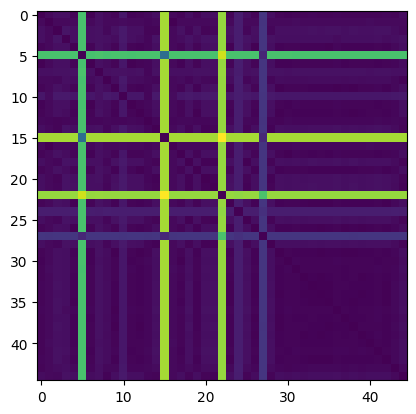

In [113]:
plt.imshow(matriciona)

In [114]:
# for each mutation, compute mean distance to all other mutations
mean_distances = matriciona.mean(axis=1)
std_distances = matriciona.std(axis=1)


In [115]:
# discard  the mutations with the highest mean distances
threshold = 4
matriciona = matriciona[mean_distances < threshold]
matriciona = matriciona[:, mean_distances < threshold]

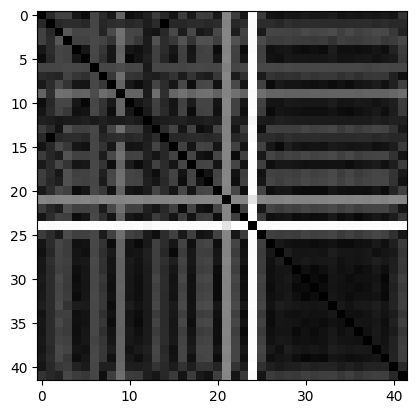

In [117]:
plt.imshow(matriciona, cmap='gray')

## K-medoids
We apply k-medoids algorithm to the protein structures.

In [155]:
from sklearn_extra.cluster import KMedoids



In [156]:
sse = []
for k in range(10):
    k_medoids = KMedoids(n_clusters=k+1, random_state=0, metric = 'precomputed').fit(matriciona) 
    sse.append(k_medoids.inertia_)
    print(k_medoids.inertia_)
    

80.28172216401242
75.69339230670637
74.864492771449
74.28076438958455
73.71122957008996
73.54766906347629
73.83841404943479
73.62346855941338
73.45844259060256
73.31839671721308


Text(0.5, 1.0, 'SSE vs Number of Clusters')

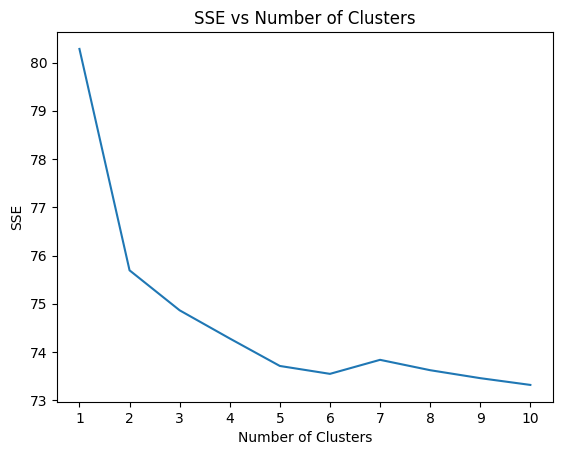

In [157]:
plt.plot( range(1,11), sse)
# set x ticks to be integers
plt.xticks(np.arange(1, 11, step=1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("SSE vs Number of Clusters")


In [158]:
# refit with k=2

k_medoids = KMedoids(n_clusters=2, random_state=0, metric = 'precomputed').fit(matriciona)

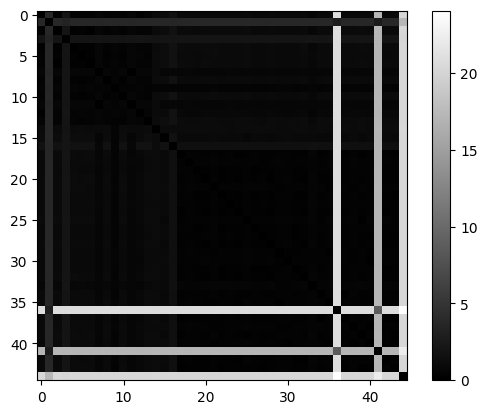

In [159]:
# order matrix by cluster
order = np.argsort(k_medoids.labels_)
clusters = k_medoids.labels_
clusters = clusters[order]
matriciona = matriciona[order, :]
matriciona = matriciona[:, order]
# colorbar
plt.imshow(matriciona, cmap='gray')
plt.colorbar()
plt.show()



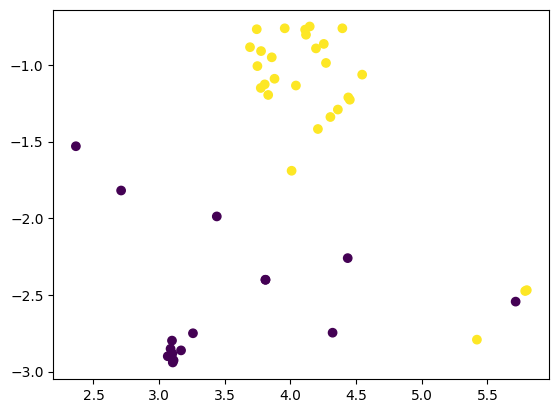

In [160]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, metric='precomputed', init='random')
X_embedded = tsne.fit_transform(matriciona)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clusters, cmap='viridis')

## Aggregation and statistics
Now we aggregate the scores by mutation, and see if there is any difference between mutations in the clusters.
From 2 clusters we pass to 3, patients with mutations in the same clusters and patients with two mutations in different clusters.

In [161]:
def get_cluster(mutation):
    path = mutation_path_dict[mutation]
    idx = paths.index(path)
    return k_medoids.labels_[idx]


df_paths['cluster1'] = df_paths['Protein change allele 1'].apply(get_cluster)
df_paths['cluster2'] = df_paths['Protein change allele 2'].apply(get_cluster)
df_paths['clusters'] = list(zip(df_paths['cluster1'], df_paths['cluster2']))

df_paths.drop(columns=['cluster1', 'cluster2'], inplace=True)
df_paths['clusters'] = df_paths['clusters'].apply(lambda x: str(set(x)))

In [169]:
# count the number of mutations in each cluster
df_paths['clusters'].value_counts()


{1}       58
{0}       23
{0, 1}    22
Name: clusters, dtype: int64

In [162]:
# mean of each metric for each cluster
mean_scores_clusters = df_paths.groupby('clusters').mean(numeric_only=True)


In [163]:

# std of each metric for each cluster
std_score_clusters = df_paths.groupby('clusters').std(numeric_only=True)


In [164]:
df_paths.columns    

Index(['Protein change allele 1', 'Protein change allele 2',
       'structure_allele1', 'structure_allele2', 'pdb_file_allele1',
       'pdb_file_allele2', 'patient', 'sex', 'birth', 'bmi',
       'physical_health_score', 'mental_health_score', 'AKUSSI_jointpain',
       'AKUSSI_spinalpain', 'KOOSpain', 'KOOSsymptoms', 'KOOSdaily_living',
       'KOOSsport', 'KOOS_QOL', 'HAQ_hapVAS', 'HAQ_haqDI', 'RMSD_A1',
       'RMSD_all_A1', 'Alignment_A1', 'RMSD_A2', 'RMSD_all_A2', 'Alignment_A2',
       'clusters'],
      dtype='object')

In [166]:
columns_to_test = ['birth', 'bmi',
       'physical_health_score', 'mental_health_score', 'AKUSSI_jointpain',
       'AKUSSI_spinalpain', 'KOOSpain', 'KOOSsymptoms', 'KOOSdaily_living',
       'KOOSsport', 'KOOS_QOL', 'HAQ_hapVAS', 'HAQ_haqDI']

for column in columns_to_test:
    cluster1 = df_paths[df_paths['clusters'] == '{0, 1}'][column]
    cluster2 = df_paths[df_paths['clusters'] == '{1}'][column]
    print(column, ttest_ind(cluster1, cluster2))

birth TtestResult(statistic=-2.375209509999903, pvalue=0.019995030517992594, df=78.0)
bmi TtestResult(statistic=-2.1219600071092666, pvalue=0.037015354621593485, df=78.0)
physical_health_score TtestResult(statistic=-1.4751218178681227, pvalue=0.1442050488759218, df=78.0)
mental_health_score TtestResult(statistic=0.24688464432338972, pvalue=0.8056461355362552, df=78.0)
AKUSSI_jointpain TtestResult(statistic=0.9412139412450494, pvalue=0.3495011467015233, df=78.0)
AKUSSI_spinalpain TtestResult(statistic=0.39871989680692616, pvalue=0.6911890465493584, df=78.0)
KOOSpain TtestResult(statistic=-1.1416332775904727, pvalue=0.25709919324776187, df=78.0)
KOOSsymptoms TtestResult(statistic=-0.5424779265276606, pvalue=0.5890359450282012, df=78.0)
KOOSdaily_living TtestResult(statistic=-1.3631657277909557, pvalue=0.17675238089131803, df=78.0)
KOOSsport TtestResult(statistic=-1.3531755513123196, pvalue=0.17990850840692296, df=78.0)
KOOS_QOL TtestResult(statistic=-1.444542841122688, pvalue=0.152591558

In [167]:
for column in columns_to_test:
    cluster1 = df_paths[df_paths['clusters'] == '{0}'][column]
    cluster2 = df_paths[df_paths['clusters'] == '{1}'][column]
    print(column, ttest_ind(cluster1, cluster2))

birth TtestResult(statistic=0.6162327263997012, pvalue=0.5395125636422967, df=79.0)
bmi TtestResult(statistic=-0.10201224380952015, pvalue=0.9190054433832485, df=79.0)
physical_health_score TtestResult(statistic=-0.6636295079210025, pvalue=0.5088595225325186, df=79.0)
mental_health_score TtestResult(statistic=1.9269195584635521, pvalue=0.05758527932293815, df=79.0)
AKUSSI_jointpain TtestResult(statistic=-0.9481791585131741, pvalue=0.34592976314030466, df=79.0)
AKUSSI_spinalpain TtestResult(statistic=-0.048559647004189584, pvalue=0.9613927864735733, df=79.0)
KOOSpain TtestResult(statistic=0.490149405713294, pvalue=0.6253867058312835, df=79.0)
KOOSsymptoms TtestResult(statistic=1.3923374163810471, pvalue=0.16772714178886977, df=79.0)
KOOSdaily_living TtestResult(statistic=0.24363578965513993, pvalue=0.808144472849384, df=79.0)
KOOSsport TtestResult(statistic=0.458259572161476, pvalue=0.6480240778787245, df=79.0)
KOOS_QOL TtestResult(statistic=1.2111939248526606, pvalue=0.2294318441576671

In [168]:
for column in columns_to_test:
    cluster1 = df_paths[df_paths['clusters'] == '{0, 1}'][column]
    cluster2 = df_paths[df_paths['clusters'] == '{0}'][column]
    print(column, ttest_ind(cluster1, cluster2))

birth TtestResult(statistic=-3.228121961751598, pvalue=0.002387224767621413, df=43.0)
bmi TtestResult(statistic=-1.9195923451447272, pvalue=0.06156028944283499, df=43.0)
physical_health_score TtestResult(statistic=-0.7906676384313891, pvalue=0.4334772754549864, df=43.0)
mental_health_score TtestResult(statistic=-1.3830901994417186, pvalue=0.1737771843671314, df=43.0)
AKUSSI_jointpain TtestResult(statistic=1.526831462586848, pvalue=0.13412577822686056, df=43.0)
AKUSSI_spinalpain TtestResult(statistic=0.39595864094657185, pvalue=0.6940934773854813, df=43.0)
KOOSpain TtestResult(statistic=-1.529407578243499, pvalue=0.13348734459019712, df=43.0)
KOOSsymptoms TtestResult(statistic=-1.6884654945859787, pvalue=0.0985625523159771, df=43.0)
KOOSdaily_living TtestResult(statistic=-1.5402288565480329, pvalue=0.13083207576300837, df=43.0)
KOOSsport TtestResult(statistic=-1.6444446494310032, pvalue=0.10737676893398457, df=43.0)
KOOS_QOL TtestResult(statistic=-2.626779622110217, pvalue=0.01189654178

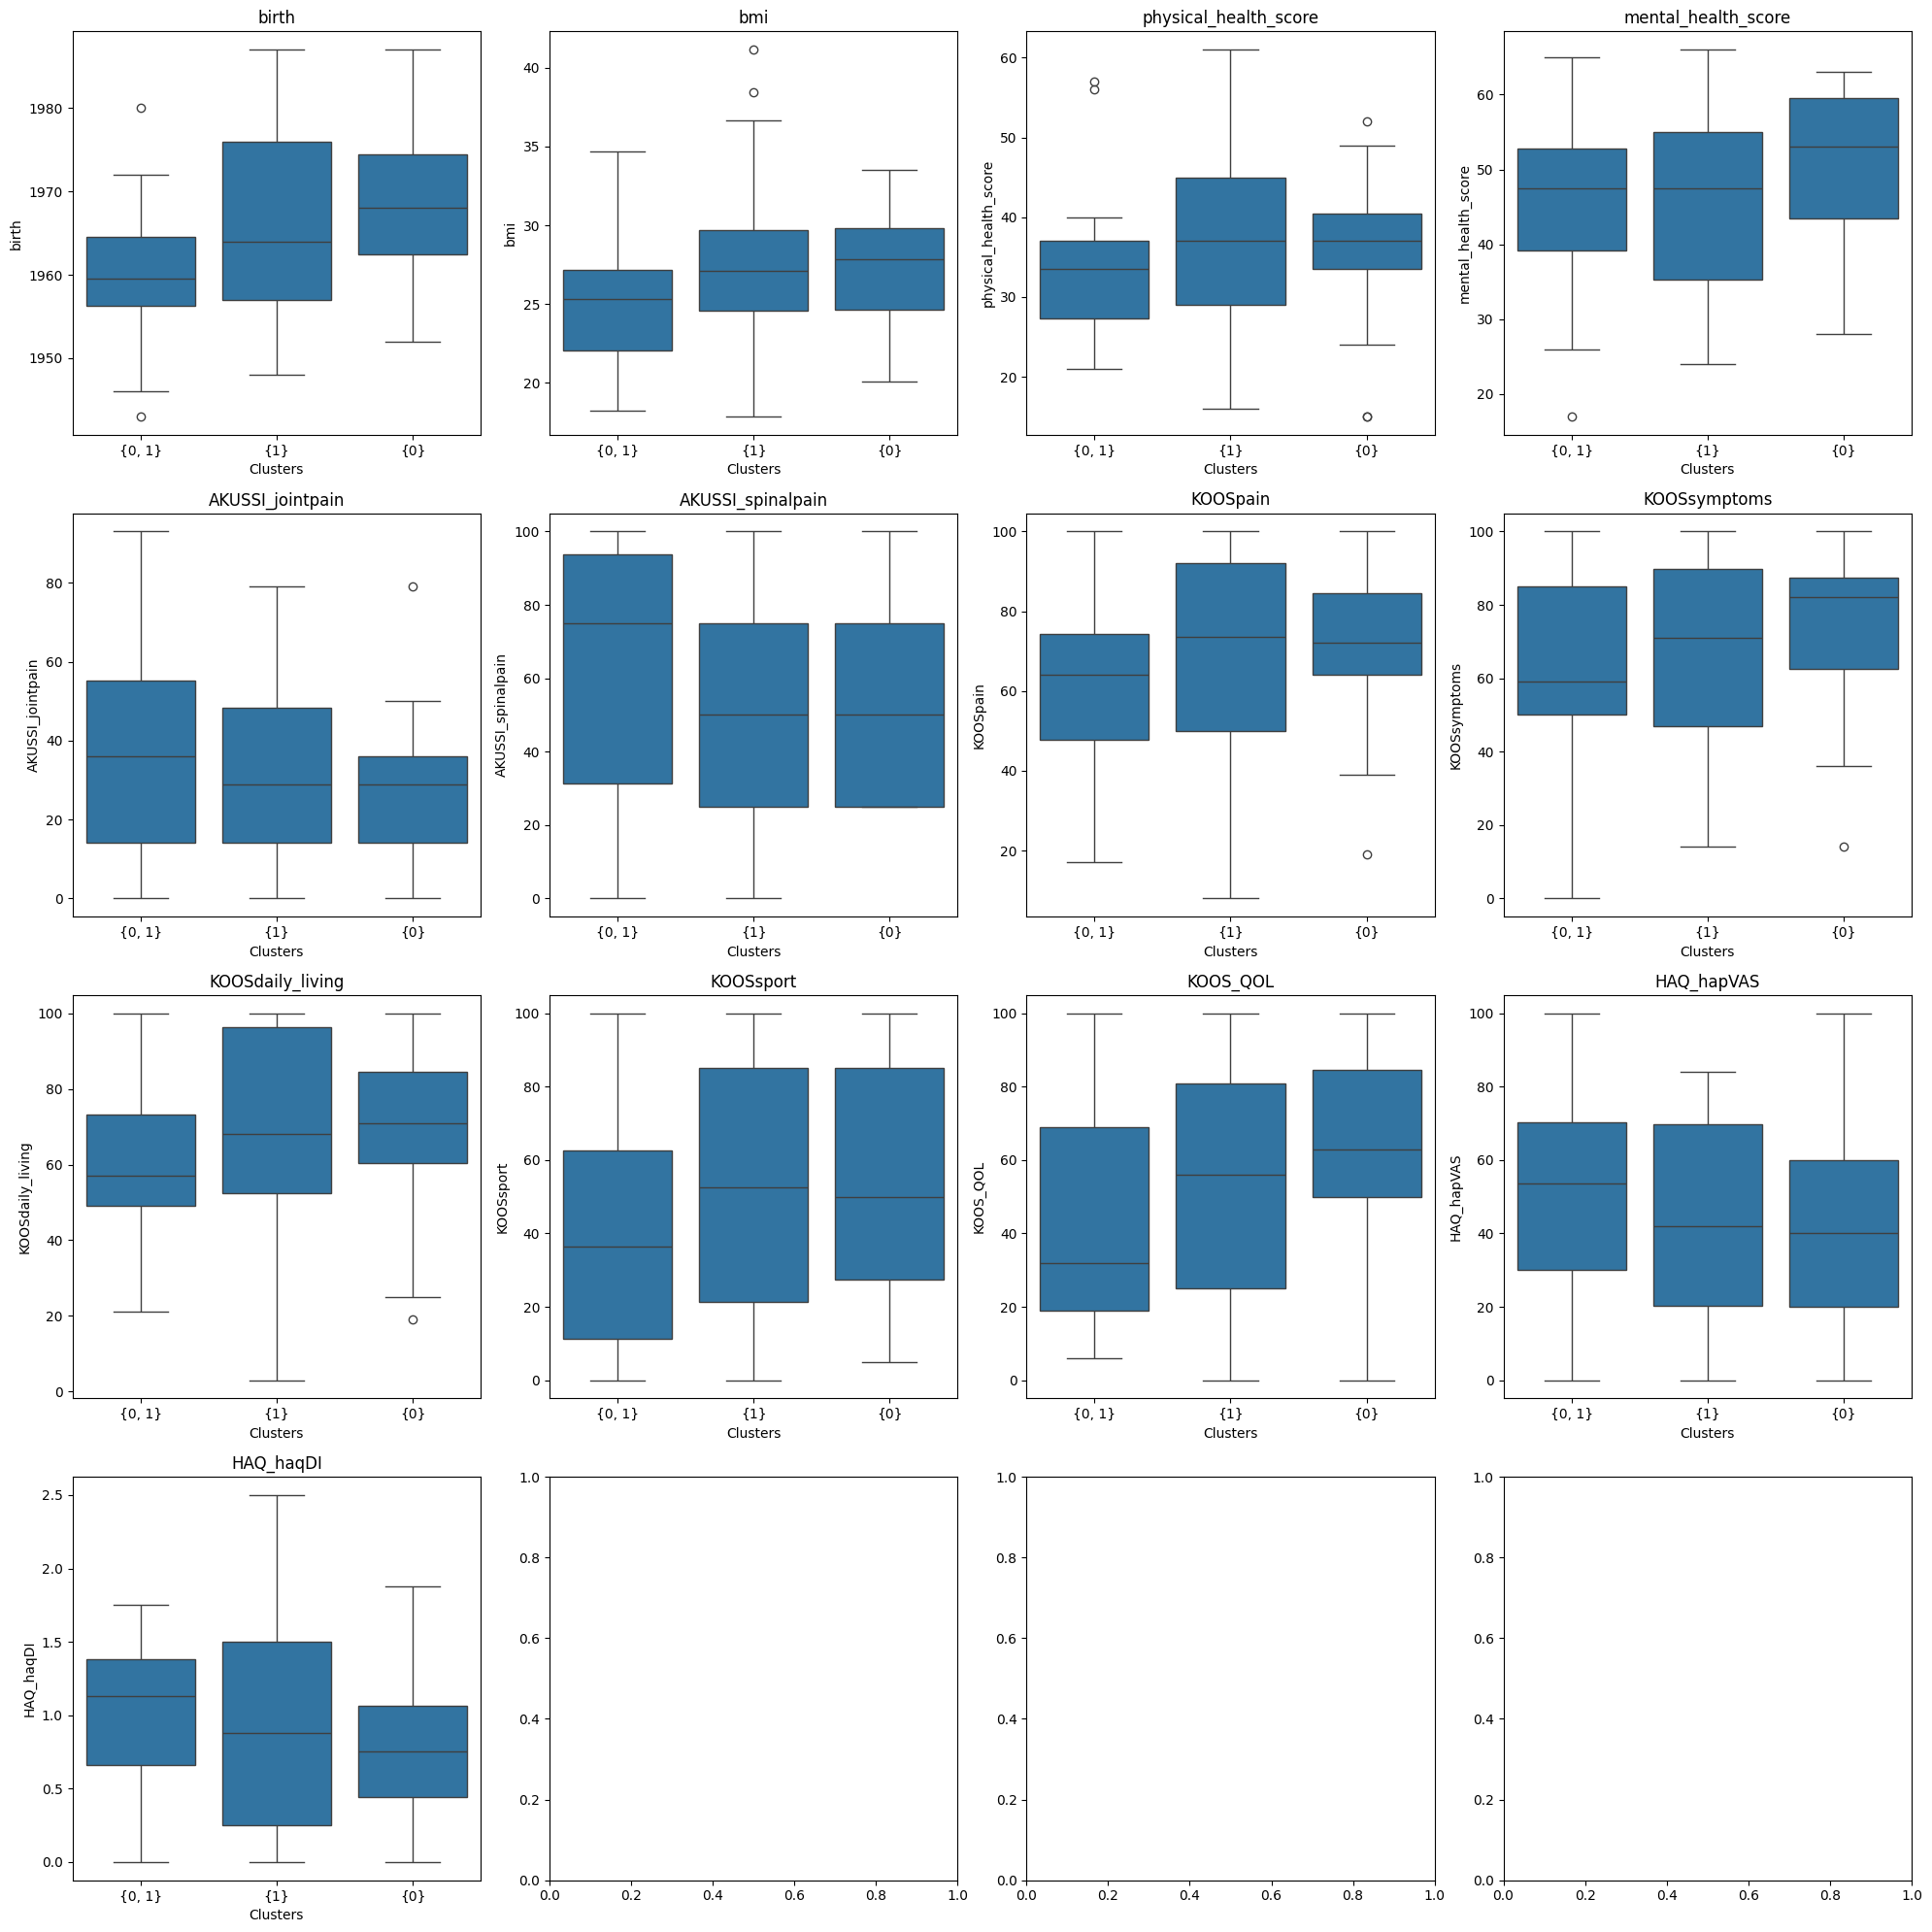

In [171]:
# plot values of each metric for each cluster
import seaborn as sns

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i, column in enumerate(columns_to_test):
    sns.boxplot(x='clusters', y=column, data=df_paths, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(column)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xlabel('Clusters')
    ax[i//4, i%4].set_ylabel(column)
    ax[i//4, i%4].set_title(column)
plt.tight_layout()
plt.show()
    

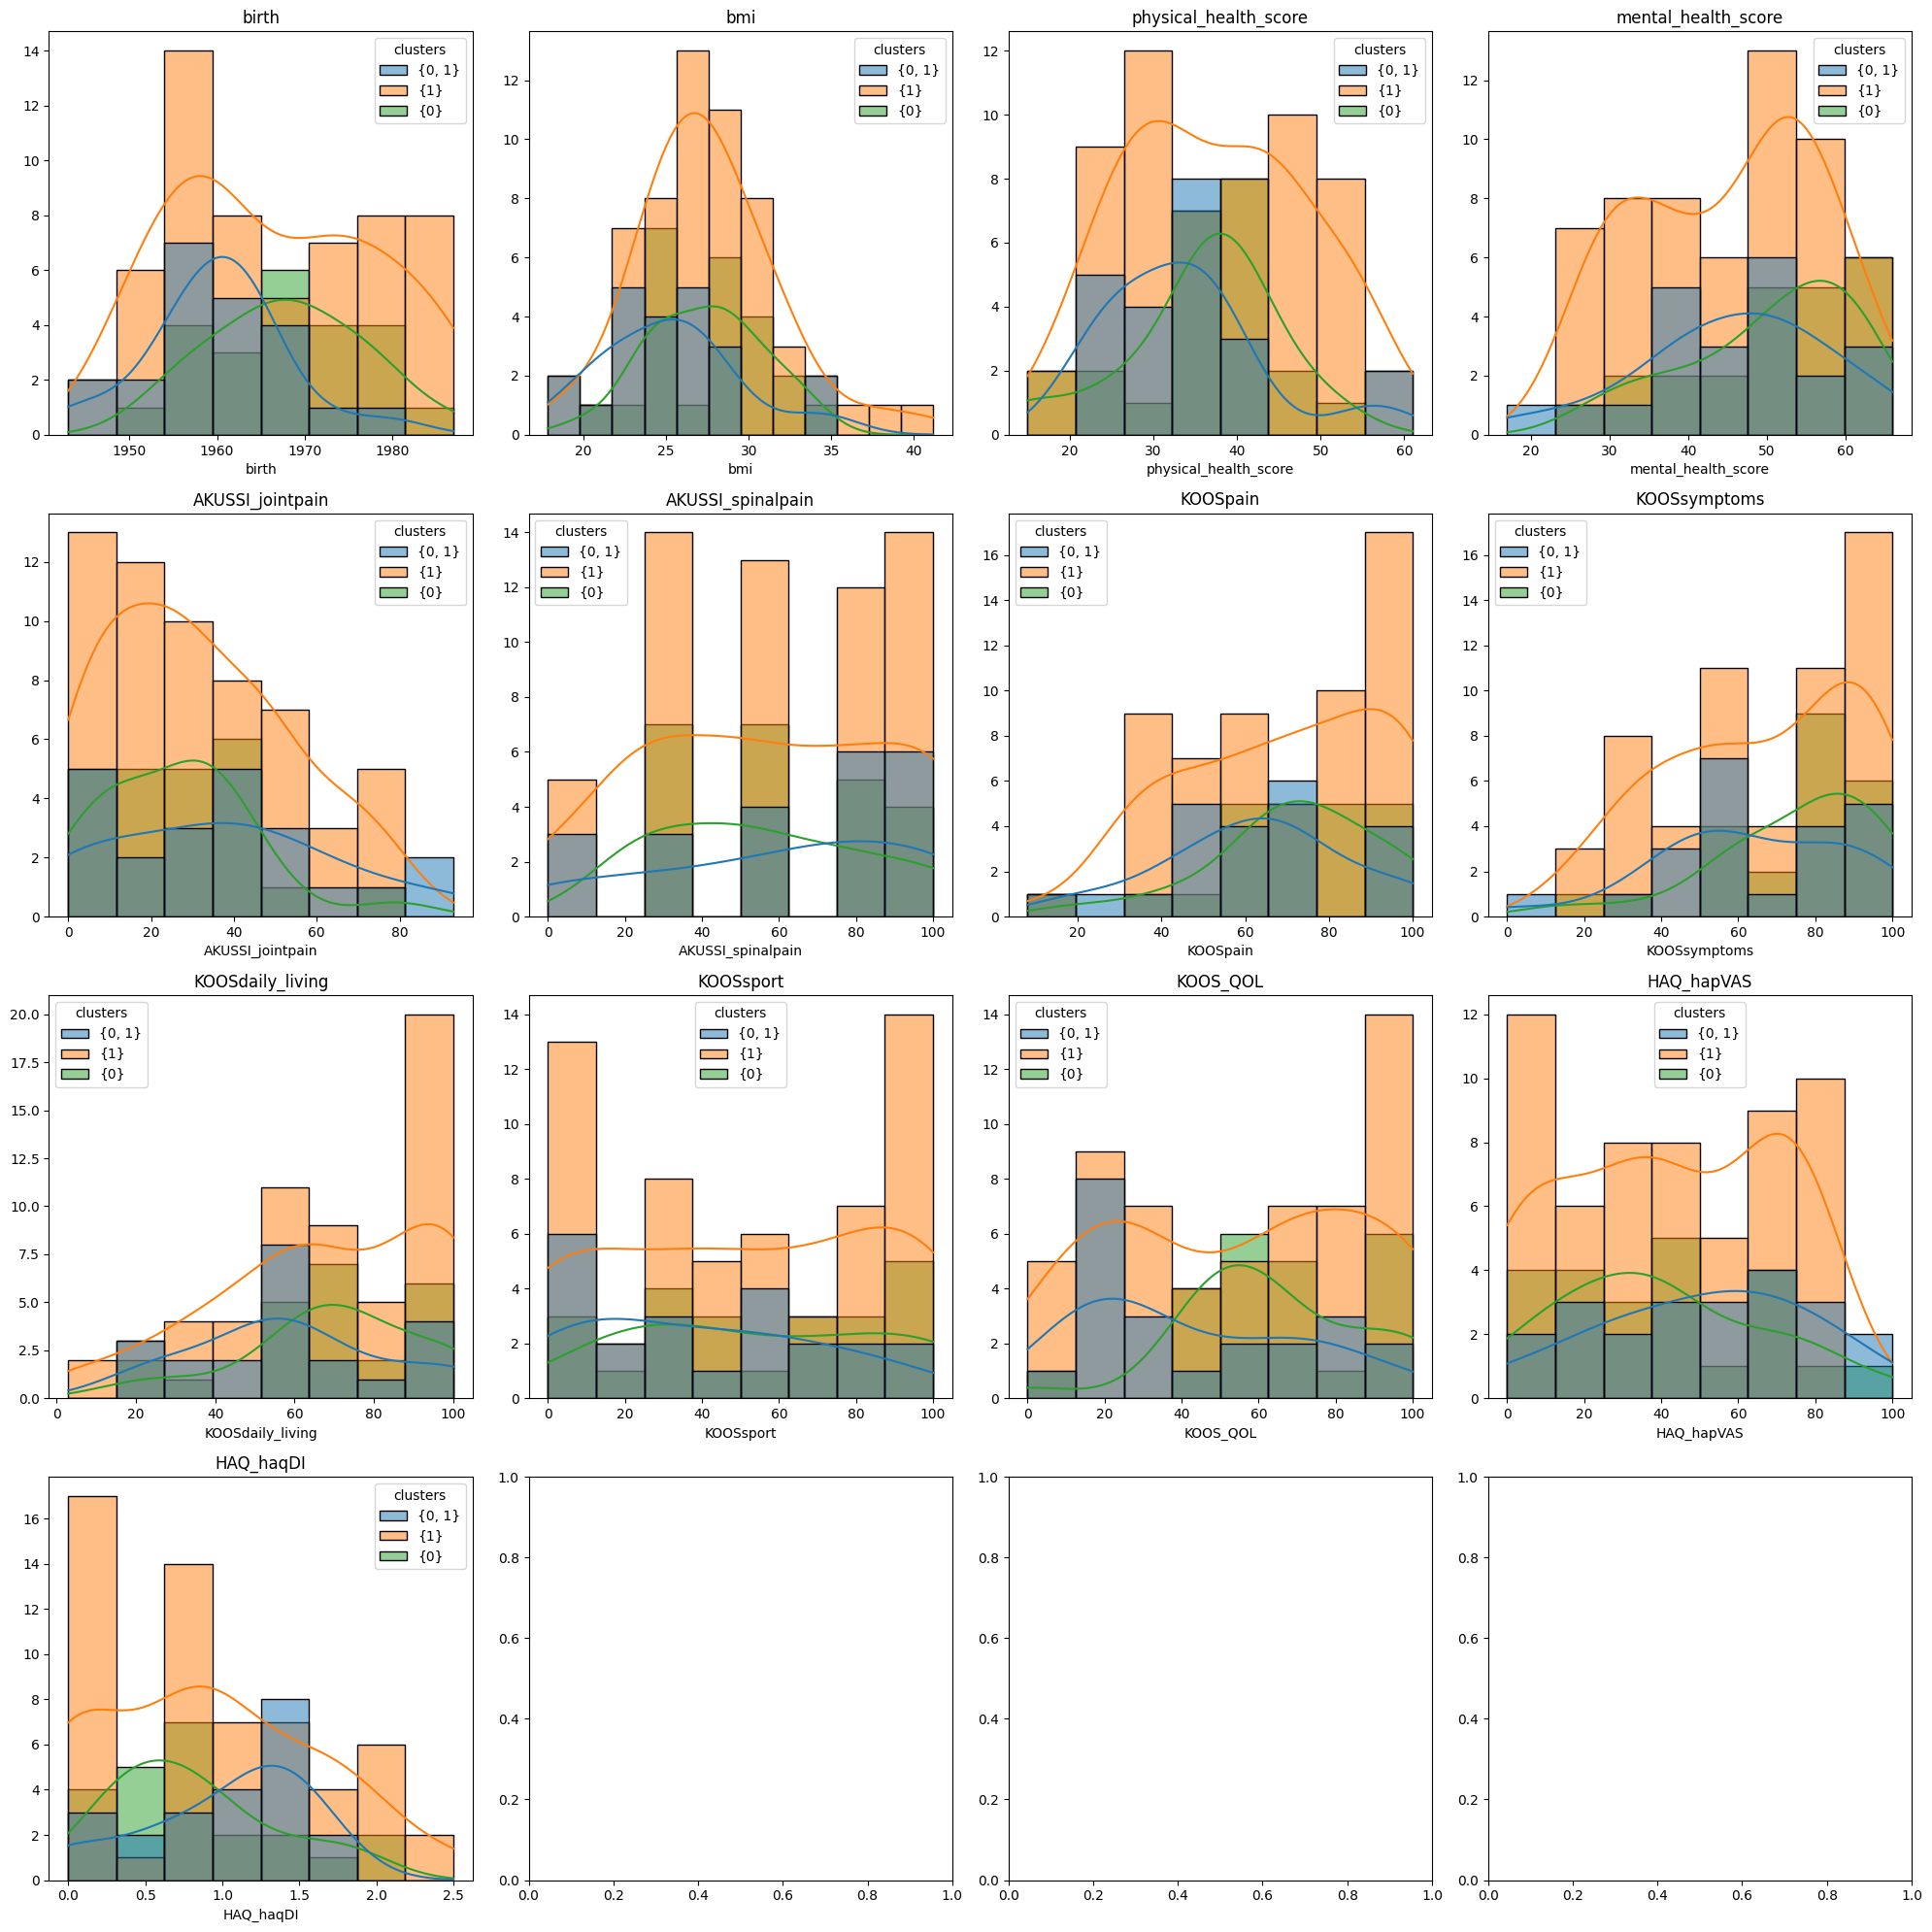

In [172]:
# plot distribution of each metric for each cluster

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i, column in enumerate(columns_to_test):
    sns.histplot(df_paths, x=column, hue='clusters', ax=ax[i//4, i%4], kde=True)
    ax[i//4, i%4].set_title(column)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xlabel(column)
    ax[i//4, i%4].set_title(column)
plt.tight_layout()
plt.show()

In [176]:
for column in columns_to_test:
    cluster1 = df_paths[(df_paths['clusters'] == '{0, 1}') | (df_paths['clusters']=='{0}')][column]
    cluster2 = df_paths[df_paths['clusters'] == '{1}'][column]
    print(column, ttest_ind(cluster1, cluster2))

birth TtestResult(statistic=-1.0782014399551474, pvalue=0.283512221767271, df=101.0)
bmi TtestResult(statistic=-1.4130761530989946, pvalue=0.16070774014119307, df=101.0)
physical_health_score TtestResult(statistic=-1.3681652846637034, pvalue=0.17429641820744785, df=101.0)
mental_health_score TtestResult(statistic=1.3556535901341176, pvalue=0.1782330206669121, df=101.0)
AKUSSI_jointpain TtestResult(statistic=0.04311491819733601, pvalue=0.965695049790844, df=101.0)
AKUSSI_spinalpain TtestResult(statistic=0.22594409780467878, pvalue=0.8217014965684598, df=101.0)
KOOSpain TtestResult(statistic=-0.41084580583948327, pvalue=0.6820559623734938, df=101.0)
KOOSsymptoms TtestResult(statistic=0.5276440269057029, pvalue=0.5989036744868486, df=101.0)
KOOSdaily_living TtestResult(statistic=-0.7095018379200221, pvalue=0.4796478419993897, df=101.0)
KOOSsport TtestResult(statistic=-0.5418441474969562, pvalue=0.5891192604416369, df=101.0)
KOOS_QOL TtestResult(statistic=-0.1523671013962716, pvalue=0.8792

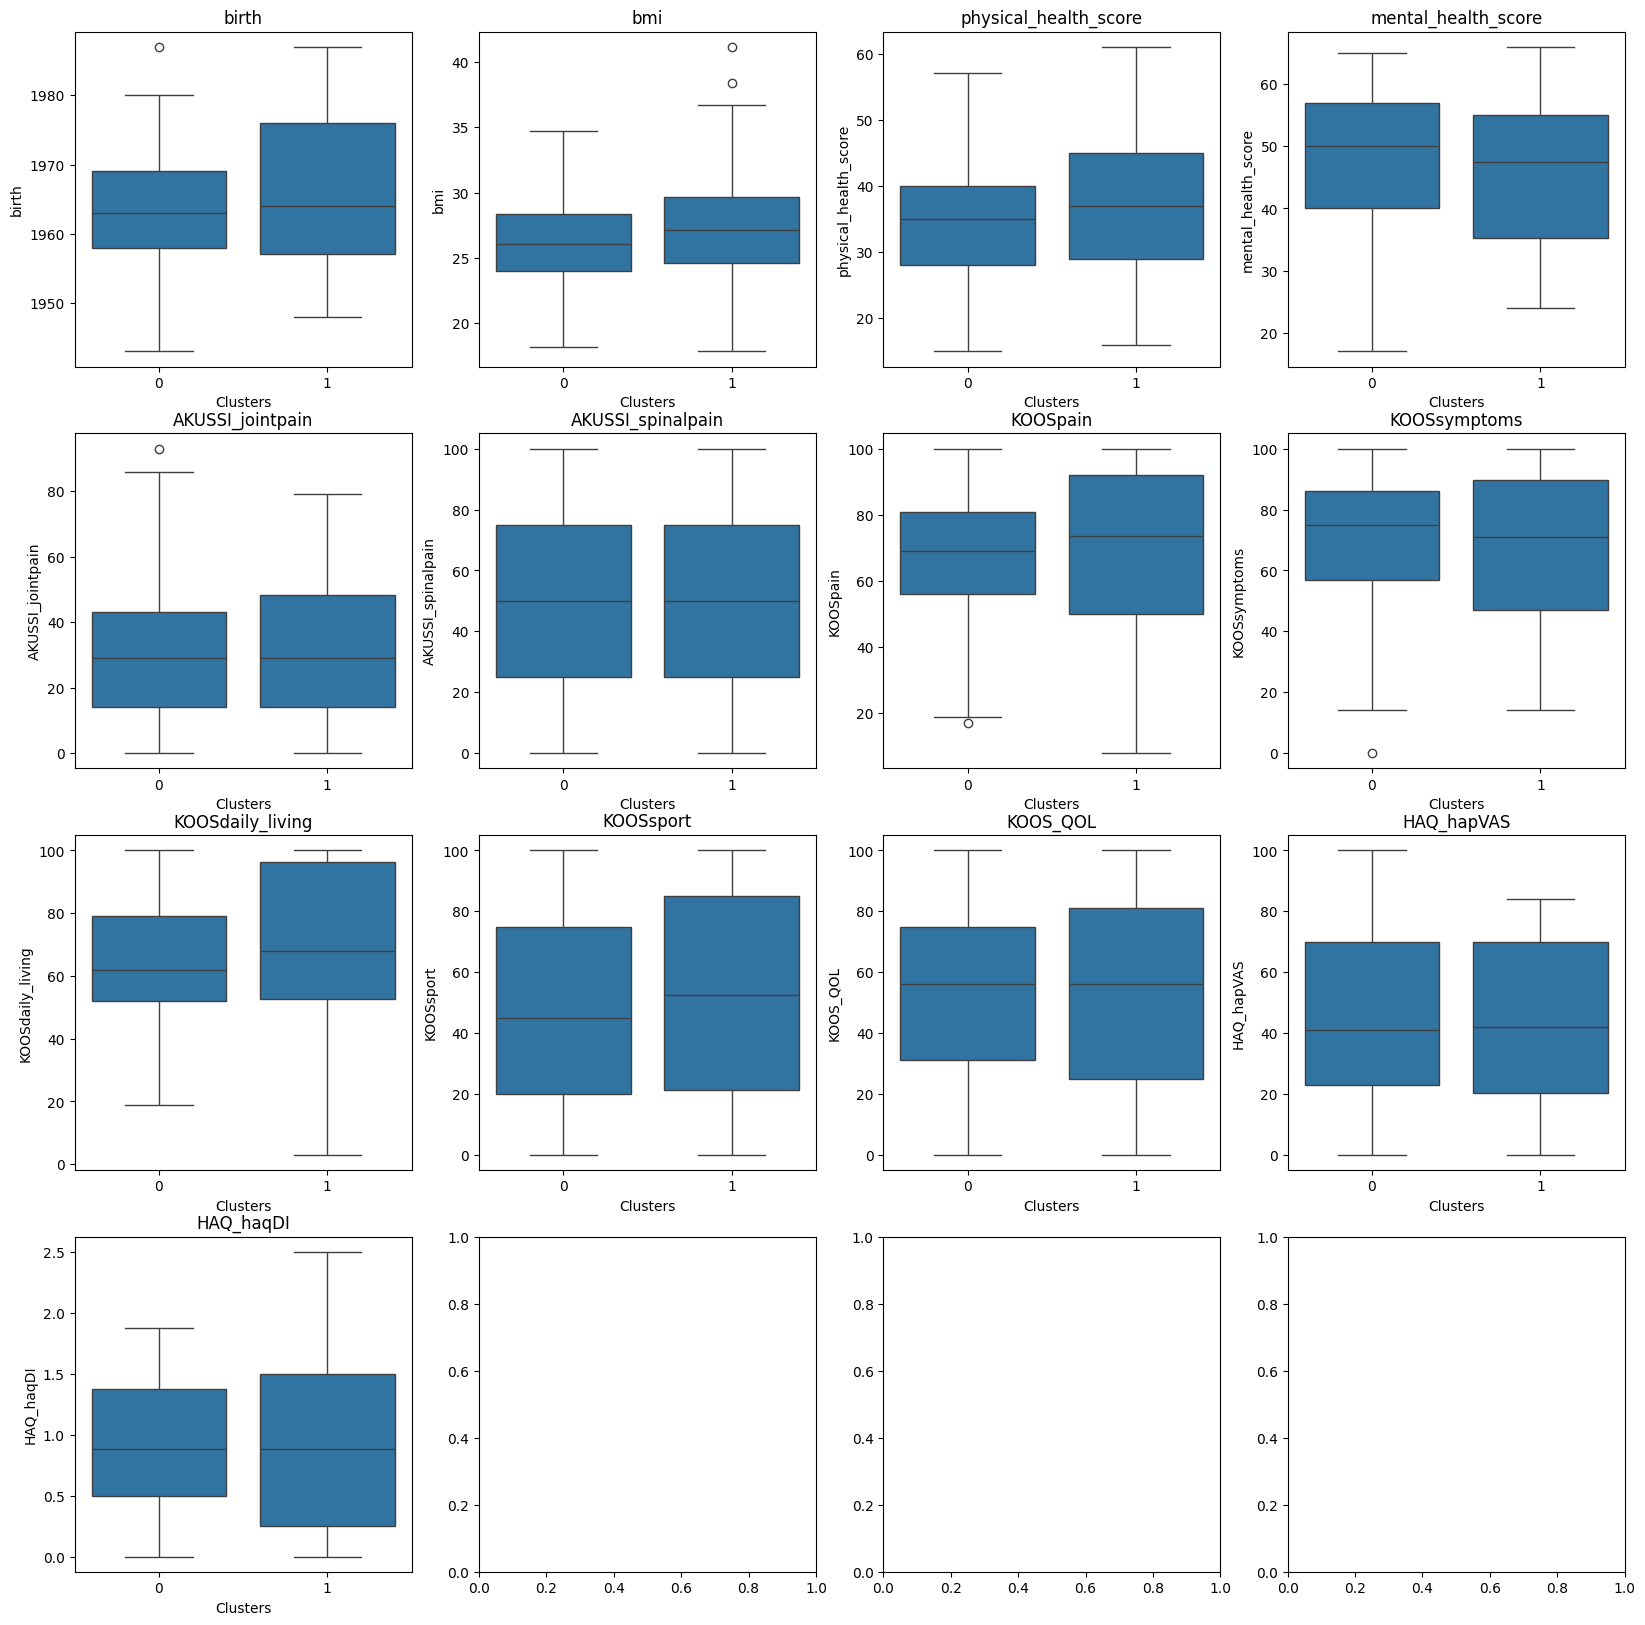

In [178]:
# plot values of each metric for each cluster with 2 clusters
import seaborn as sns

clusters = df_paths['clusters'].apply(lambda x: x[1:-1].split(', '))
df_paths['cluster1'] = clusters.apply(lambda x: int(x[0]))

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i, column in enumerate(columns_to_test):
    sns.boxplot(x='cluster1', y=column, data=df_paths, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(column)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xlabel('Clusters')
    ax[i//4, i%4].set_ylabel(column)
    ax[i//4, i%4].set_title(column)

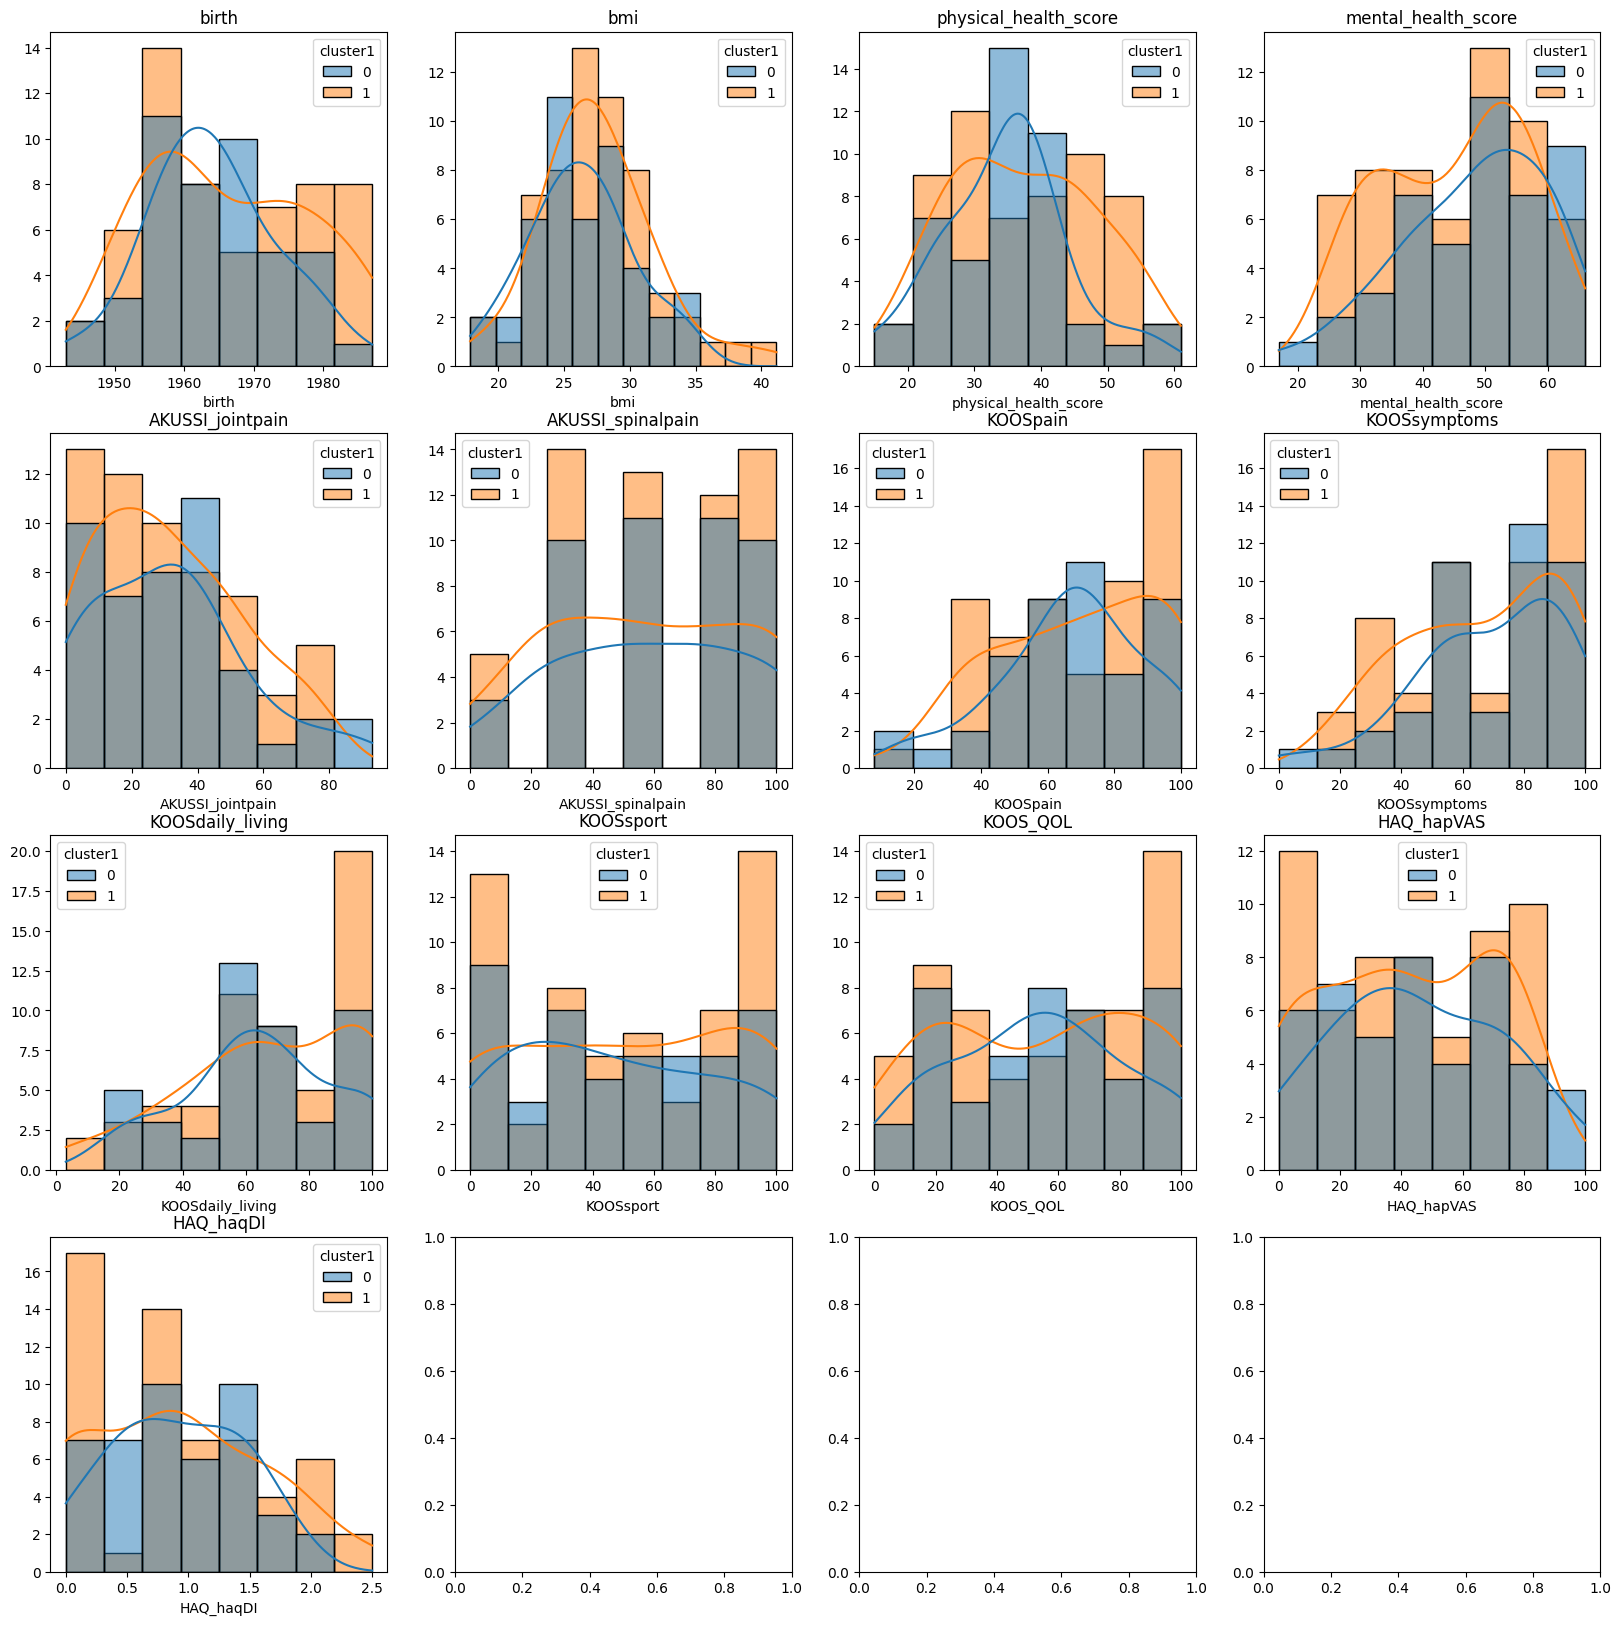

In [179]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i, column in enumerate(columns_to_test):
    sns.histplot(df_paths, x=column, hue='cluster1', ax=ax[i//4, i%4], kde=True)
    ax[i//4, i%4].set_title(column)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xlabel(column)
    ax[i//4, i%4].set_title(column)